In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from progressbar import ProgressBar
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib
import itertools


In [9]:
df_orders_dec = pd.read_csv('../data/raw/orders_before_dec.csv',sep='|')
df_orders_dec

,date,userID,itemID,order
0,2020-06-01,38769,3477,1
1,2020-06-01,42535,30474,1
2,2020-06-01,42535,15833,1
3,2020-06-01,42535,20131,1
4,2020-06-01,42535,4325,1
...,...,...,...,...
767126,2020-11-30,22541,746,1
767127,2020-11-30,36315,22834,20
767128,2020-11-30,7736,18630,3
767129,2020-11-30,7736,29657,8


In [3]:
# Mini dataset
#df_orders_dec = df_orders_dec[(df_orders_dec['userID'].isin( range(0,150)))]
#df_orders_dec

In [154]:
df_gold_dec = pd.read_csv('../data/gold_dec.csv',sep='|')
df_gold_dec

,userID,itemID,prediction
0,0,20664,2
1,0,28231,2
2,13,2690,4
3,15,1299,4
4,15,20968,4
...,...,...,...
9740,46118,20106,4
9741,46124,19677,4
9742,46125,12878,0
9743,46127,7963,2


## EDA

In [5]:
pd.DataFrame(df_orders_dec['userID'].astype(str)+'_'+df_orders_dec['itemID'].astype(str)).nunique()


0    667301
dtype: int64

(1.0, 10.0)

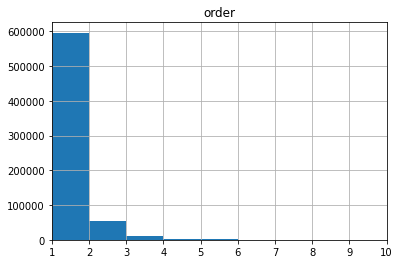

In [271]:
df_orders_dec.groupby(['userID', 'itemID']).count()[['order']].hist(bins=22)
plt.xlim(1,10)

(1.0, 70.0)

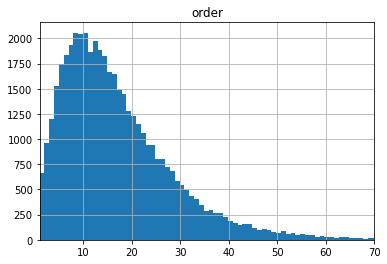

In [264]:
df_orders_dec.groupby(['userID']).count()[['order']].hist(bins=203)
plt.xlim(1,70)

(1.0, 30.0)

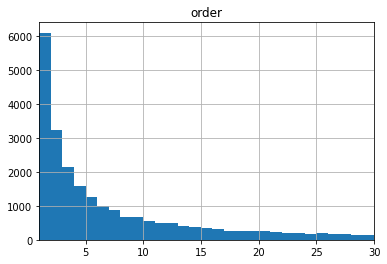

In [9]:
df_orders_dec.groupby(['itemID']).sum()[['order']].hist(bins=20761)
plt.xlim(1,30)

## Transformations

### Add dates features

In [10]:
def date_features(df):
    # Date Features
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df.date.dt.month
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    #df['day'] = df.date.dt.day
    #df['year'] = df.date.dt.year
    
    # Generate correponding week starting from the last day of the month
    dayofyear = df.date.dt.dayofyear
    n, p = max(dayofyear), min(dayofyear)
    week = math.ceil((n-p+1)/7)
    df['week'] = 0
    while n >= p:
        m = n-7
        df['week'] = np.where((dayofyear>m)&(dayofyear<=n), week, df['week'])
        week -= 1
        n = m
    
    # Number of days since last order of a product per item
    df.sort_values(['userID', 'itemID', 'dayofyear'], inplace=True)
    df['n_days'] = df['dayofyear'] - df.groupby(['userID', 'itemID'])['dayofyear'].shift(1)
    df['n_days'] = df['n_days'].fillna(0)
    
    # Drop date
    df.drop('date', axis=1, inplace=True)

    return df

In [11]:
df_orders_dec = date_features(df_orders_dec)
df_orders_dec

,userID,itemID,order,month,dayofweek,dayofyear,week,n_days
390966,0,1505,1,9,1,245,15,0.0
709719,0,9325,1,11,4,325,26,0.0
268197,0,12468,1,8,0,216,10,0.0
334333,0,12505,1,8,1,231,13,0.0
268196,0,15083,1,8,0,216,10,0.0
...,...,...,...,...,...,...,...,...
453489,46137,2667,1,9,3,261,17,0.0
287155,46137,20209,1,8,5,221,11,0.0
287156,46137,28343,1,8,5,221,11,0.0
287097,46137,28900,2,8,5,221,11,0.0


In [12]:
#df_orders_dec[(df_orders_dec['ndays']!=0)] # maybe use this cut to train after filling

### Transform  dataset into a week based

In [18]:
def week_features(df):
    # Number of days since last order of a user per item
    df.sort_values(['userID', 'itemID', 'week'], inplace=True)
    df['n_weeks'] = df['week'] - df.groupby(['userID', 'itemID'])['week'].shift(1)
    df['n_weeks'] = df['n_weeks'].fillna(0)
    
    #Order of last time a user order that item
    df['order_last'] = df.groupby(['userID', 'itemID'])['order'].shift(1)
    df['order_last'] = df['order_last'].fillna(0)
    
    #Order of last time a user order that item
    #df['order_diff_last'] = df.groupby(['userID', 'itemID'])['order'].diff(1)
    
    return df

In [19]:
df_orders_dec_w = df_orders_dec.groupby(['userID', 'itemID', 'week'], 
                                        as_index=False).agg(order=('order','sum'),
                                                            month_avg= ('month','mean'), 
                                                            dayofweek_avg=('dayofweek','mean'),
                                                            n_days_avg =('n_days','mean'),
                                                           )

df_orders_dec_w = week_features(df_orders_dec_w)
df_orders_dec_w


,userID,itemID,week,order,month_avg,dayofweek_avg,n_days_avg,n_weeks,order_last
0,0,1505,15,1,9.0,1.0,0.0,0.0,0.0
1,0,9325,26,1,11.0,4.0,0.0,0.0,0.0
2,0,12468,10,1,8.0,0.0,0.0,0.0,0.0
3,0,12505,13,1,8.0,1.0,0.0,0.0,0.0
4,0,15083,10,1,8.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
765672,46137,2667,17,1,9.0,3.0,0.0,0.0,0.0
765673,46137,20209,11,1,8.0,5.0,0.0,0.0,0.0
765674,46137,28343,11,1,8.0,5.0,0.0,0.0,0.0
765675,46137,28900,11,2,8.0,5.0,0.0,0.0,0.0


In [22]:
df_orders_dec_w[(df_orders_dec_w['order_last']!=0)]

,userID,itemID,week,order,month_avg,dayofweek_avg,n_days_avg,n_weeks,order_last
6,0,20664,20,1,10.0,4.0,126.0,18.0,1.0
16,1,23055,27,2,11.0,6.0,20.0,3.0,1.0
28,2,23476,18,1,9.0,2.0,86.0,13.0,1.0
36,2,30829,21,1,10.0,0.0,112.0,16.0,1.0
38,3,4135,22,1,10.0,1.0,61.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...
765575,46131,32646,13,1,8.0,6.0,56.0,8.0,1.0
765577,46132,1303,27,1,11.0,2.0,65.0,10.0,1.0
765590,46133,5468,25,1,11.0,5.0,47.0,7.0,1.0
765626,46134,21901,17,2,9.0,1.0,51.0,8.0,1.0


### Fill weeks with no purchases

In [7]:
df_ui_unique_dec = df_orders_dec_w.groupby(['userID', 'itemID']).count().reset_index()[['userID', 'itemID']]
end = df_orders_dec_w['week'].max()

ls_user = []
ls_item = []
ls_week = []

pbar = ProgressBar()
for x in pbar(range(0, len(df_ui_unique_dec))):
    u, i = df_ui_unique_dec.loc[x]
    
    start = df_orders_dec_w[(df_orders_dec_w['userID']==u)&(df_orders_dec_w['itemID']==i)]['week'].min()
    
    ws = list(range(start, end+1))
    len_ws = len(ws)
    ls_week.append(ws)
    ls_user.append([u]*len_ws)
    ls_item.append([i]*len_ws)

df_user_item_dec_w = pd.DataFrame({'week':list(itertools.chain.from_iterable(ls_week)), 
                                   'userID':list(itertools.chain.from_iterable(ls_user)), 
                                   'itemID':list(itertools.chain.from_iterable(ls_item))})
df_user_item_dec_w.reset_index(inplace=True, drop=True)
df_user_item_dec_w.to_csv('../data/interim/orders_str_before_dec.csv',sep='|', index=False)

df_user_item_dec_w

,week,userID,itemID
0,15,0,1505
1,16,0,1505
2,17,0,1505
3,18,0,1505
4,19,0,1505
...,...,...,...
9493630,23,46137,32292
9493631,24,46137,32292
9493632,25,46137,32292
9493633,26,46137,32292


In [35]:
df_orders_dec_c = df_user_item_dec_w.merge(df_orders_dec_w, 
                                   how='left', 
                                   left_on=['userID', 'itemID', 'week'], 
                                   right_on=['userID', 'itemID', 'week'])

#Filling Nans
df_orders_dec_c['order'] = df_orders_dec_c['order'].fillna(0)
#df_orders_dec_c['order_last'] = df_orders_dec_c.groupby(['userID', 'itemID'])['order_last'].apply(lambda x: x.bfill())

df_orders_dec_c.to_csv('../data/interim/orders_before_dec_complete.csv',sep='|', index=False)
df_orders_dec_c


,week,userID,itemID,order,month_avg,dayofweek_avg,n_days_avg,n_weeks,order_last
0,15,0,1505,1.0,9.0,1.0,0.0,0.0,0.0
1,16,0,1505,0.0,NaN,NaN,NaN,NaN,NaN
2,17,0,1505,0.0,NaN,NaN,NaN,NaN,NaN
3,18,0,1505,0.0,NaN,NaN,NaN,NaN,NaN
4,19,0,1505,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9493630,23,46137,32292,0.0,NaN,NaN,NaN,NaN,NaN
9493631,24,46137,32292,0.0,NaN,NaN,NaN,NaN,NaN
9493632,25,46137,32292,0.0,NaN,NaN,NaN,NaN,NaN
9493633,26,46137,32292,0.0,NaN,NaN,NaN,NaN,NaN


In [36]:
#df_orders_dec_c[(df_orders_dec_c['userID']==22696)&(df_orders_dec_c['itemID']==840)]

## Train / Validation Split

In [ ]:
#df_orders_dec_c = pd.read_csv('../data/interim/orders_before_dec_complete.csv',sep='|')

In [107]:
# Select features
features = ['week', 'userID', 'itemID', 'order']
df_complete = df_orders_dec_c[features].copy()

In [108]:
# Split
split_point = df_complete['week'].max()-4
df_train = df_complete[df_complete['week'] < split_point].copy()
df_val = df_complete[df_complete['week'] >= split_point].copy()
df_train.head()


,week,userID,itemID,order
0,15,0,1505,1.0
1,16,0,1505,0.0
2,17,0,1505,0.0
3,18,0,1505,0.0
4,19,0,1505,0.0


In [109]:
# Create labels for 4-steps train 
df_train['w1'] = df_train.groupby(['userID', 'itemID'])['order'].shift(-1)
df_train['w2'] = df_train.groupby(['userID', 'itemID'])['order'].shift(-2)
df_train['w3'] = df_train.groupby(['userID', 'itemID'])['order'].shift(-3)
df_train['w4'] = df_train.groupby(['userID', 'itemID'])['order'].shift(-4)
df_train = df_train.dropna(subset=['w1','w2','w3','w4'])
df_train.drop('order', axis=1, inplace=True)

df_train

,week,userID,itemID,w1,w2,w3,w4
0,15,0,1505,0.0,0.0,0.0,0.0
1,16,0,1505,0.0,0.0,0.0,0.0
2,17,0,1505,0.0,0.0,0.0,0.0
3,18,0,1505,0.0,0.0,0.0,0.0
15,10,0,12468,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
9493621,14,46137,32292,0.0,0.0,0.0,0.0
9493622,15,46137,32292,0.0,0.0,0.0,0.0
9493623,16,46137,32292,0.0,0.0,0.0,0.0
9493624,17,46137,32292,0.0,0.0,0.0,0.0


In [110]:
# Create labels for 4-steps validation 
df_val['w1'] = df_val.groupby(['userID', 'itemID'])['order'].shift(-1)
df_val['w2'] = df_val.groupby(['userID', 'itemID'])['order'].shift(-2)
df_val['w3'] = df_val.groupby(['userID', 'itemID'])['order'].shift(-3)
df_val['w4'] = df_val.groupby(['userID', 'itemID'])['order'].shift(-4)
df_val = df_val.dropna(subset=['w1','w2','w3','w4'])
df_val.drop('order', axis=1, inplace=True)

df_val

,week,userID,itemID,w1,w2,w3,w4
8,23,0,1505,0.0,0.0,0.0,0.0
28,23,0,12468,0.0,0.0,0.0,0.0
43,23,0,12505,0.0,0.0,0.0,0.0
61,23,0,15083,0.0,0.0,0.0,0.0
87,23,0,20664,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
9493562,23,46137,2667,0.0,0.0,0.0,0.0
9493579,23,46137,20209,0.0,0.0,0.0,0.0
9493596,23,46137,28343,0.0,0.0,0.0,0.0
9493613,23,46137,28900,0.0,0.0,0.0,0.0


## Create Basic Time-Series Features

In [111]:
def lags(df, ls):
    for n in ls:
        df['lag_order_%s'%n] = df.groupby(['userID', 'itemID'])['order'].shift(n)
    return df
        
def diff(df, ls):
    for n in ls:
        df['dif_order_%s'%n] = df.groupby(['userID', 'itemID'])['order'].diff(n)
    return df

def roll_mean(df, ls):
    for n in ls:
        df['mean_order_%s'%n] = df.groupby(['userID', 'itemID'])['order'].rolling(n).mean().reset_index(level=[0,1], drop=True)
    return df

def roll_std(df, ls):
    for n in ls:
        df['std_order_%s'%n] = df.groupby(['userID', 'itemID'])['order'].rolling(n).std().reset_index(level=[0,1], drop=True)
    return df

    


In [118]:
# Could be better for val features
df_complete = lags(df_complete, range(1,9))
df_complete = diff(df_complete, range(1,5))
df_complete = roll_mean(df_complete, [4,8])
df_complete = roll_std(df_complete, [4,8])
df_complete.to_csv('../data/interim/orders_before_dec_features.csv',sep='|')


In [120]:
# Insert features to the train and validation dataframe
df_train = df_train.merge(df_complete, 
                          how='left', 
                          left_on=['userID', 'itemID', 'week'], 
                          right_on=['userID', 'itemID', 'week'])

df_val = df_val.merge(df_complete, 
                      how='left', 
                      left_on=['userID', 'itemID', 'week'], 
                      right_on=['userID', 'itemID', 'week'])

df_gold_dec['week'] = df_complete['week'].max()
df_test = df_gold_dec[['userID', 'itemID', 'week']].merge(df_complete, 
                                                          how='left', 
                                                          left_on=['userID', 'itemID', 'week'], 
                                                          right_on=['userID', 'itemID', 'week'])



## Train Models

In [212]:
y_features = ['w1', 'w2','w3','w4']
X_features = ['order','lag_order_2', 'lag_order_3', 'lag_order_4', 'lag_order_5',
              'dif_order_1', 'dif_order_2', 'dif_order_3', 'dif_order_4',
              'mean_order_4', 'mean_order_8', 'std_order_4', 'std_order_8'
             ]
train = df_train[y_features+X_features] #.dropna().drop_duplicates()
val = df_val[y_features+X_features]

imputer = SimpleImputer(strategy='most_frequent')
X_train = imputer.fit_transform(train[X_features])
y_train = train[y_features]

X_val = imputer.fit_transform(val[X_features])
y_val = val[y_features]

4354250
1651064
10877

### RFR

In [218]:
rfr = RandomForestRegressor(n_estimators=100, random_state=46, n_jobs=-1)
rfr.fit(X_train, y_train)
                
joblib.dump(rfr, '../models/pred_dec_rfr.sav')

['../models/pred_dec_rfr.sav']

### XGB

In [253]:
# XGB Model
matrix_train = xgb.DMatrix(X_train, label = y_train)
matrix_val = xgb.DMatrix(X_val, label = y_val)

# Run XGB 
xgreg = xgb.train(params={'objective':'reg:linear','eval_metric':'mae'},
                  dtrain = matrix_train, num_boost_round = 500,
                  early_stopping_rounds = 20, evals = [(matrix_train,'train'),(matrix_val,'val')],)


[04:11:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:0.36882	val-mae:0.36775
[1]	train-mae:0.27069	val-mae:0.26980
[2]	train-mae:0.20199	val-mae:0.20106
[3]	train-mae:0.15389	val-mae:0.15300
[4]	train-mae:0.12019	val-mae:0.11952
[5]	train-mae:0.09661	val-mae:0.09592
[6]	train-mae:0.08009	val-mae:0.07935
[7]	train-mae:0.06852	val-mae:0.06777
[8]	train-mae:0.06042	val-mae:0.05967
[9]	train-mae:0.05473	val-mae:0.05407
[10]	train-mae:0.05075	val-mae:0.05013
[11]	train-mae:0.04796	val-mae:0.04732
[12]	train-mae:0.04601	val-mae:0.04536
[13]	train-mae:0.04463	val-mae:0.04409
[14]	train-mae:0.04367	val-mae:0.04318
[15]	train-mae:0.04299	val-mae:0.04254
[16]	train-mae:0.04250	val-mae:0.04213
[17]	train-mae:0.04216	val-mae:0.04183
[18]	train-mae:0.04193	val-mae:0.04162
[19]	train-mae:0.04175	val-mae:0.04148
[20]	train-mae:0.04162

## Models Prediction

In [248]:
X_test = imputer.fit_transform(df_test[training_features])
rfr_p = np.around(rfr.predict(X_test))

df_test_pred = pd.DataFrame(rfr_p, columns = ['w1','w2','w3','w4'])
conditions = [
    (df_test_pred['w1'] >0),
    (df_test_pred['w2'] >0),
    (df_test_pred['w3'] >0),
    (df_test_pred['w4'] >0)
    ]
choices = [1,2,3,4]

df_pred_dec_rfr = df_gold_dec[['userID', 'itemID']].copy()
df_pred_dec_rfr['prediction'] = np.select(conditions, choices, default=0)
df_pred_dec_rfr.to_csv('../data/predictions/pred_dec_rfr.csv',sep='|', index=False)

In [249]:
X_test = imputer.fit_transform(df_test[training_features])
matrix_test = xgb.DMatrix(X_test)
xgreg_p = np.around(xgreg.predict(matrix_test, ntree_limit=xgreg.best_ntree_limit))

df_test_pred = pd.DataFrame(xgreg_p, columns = ['w1','w2','w3','w4'])
conditions = [
    (df_test_pred['w1'] >0),
    (df_test_pred['w2'] >0),
    (df_test_pred['w3'] >0),
    (df_test_pred['w4'] >0)
    ]
choices = [1,2,3,4]

df_pred_dec_xgreg = df_gold_dec[['userID', 'itemID']].copy()
df_pred_dec_xgreg['prediction'] = np.select(conditions, choices, default=0)
df_pred_dec_xgreg.to_csv('../data/predictions/pred_dec_xgreg.csv',sep='|', index=False)